In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgbm
import gc
import xgboost as xgb

In [3]:
items           = pd.read_csv('items.csv')
item_categories = pd.read_csv('item_categories.csv')
shops           = pd.read_csv('shops.csv')
sales_train     = pd.read_csv('sales_train_v2.csv')
test            = pd.read_csv('test.csv')
sample_submission            = pd.read_csv('sample_submission.csv')

In [4]:
transactions = sales_train.copy()
transactions[['day','month', 'year']] = transactions['date'].str.split('.', expand=True).astype(int)


In [5]:
w_cat_ids = transactions.set_index('item_id').join(items.set_index('item_id'))
w_cat_ids = w_cat_ids.reset_index()
w_cat_ids['row_id'] = w_cat_ids.index

In [6]:
w_cat_ids['item_shop_count_block'] = w_cat_ids.groupby(['date_block_num', 'shop_id', 'item_id'])['item_cnt_day'].transform('sum').clip(0,20)

In [8]:
global_mean = w_cat_ids.groupby(['date_block_num','shop_id','item_id'])['item_cnt_day'].sum().mean()
block_nums = w_cat_ids['date_block_num'].nunique()
number_of_shops =  w_cat_ids['shop_id'].nunique()

In [9]:
w_cat_ids['shop_global_mean'] = w_cat_ids.groupby(['shop_id'])['shop_id'].transform('nunique')
w_cat_ids['shop_count_block'] = w_cat_ids.groupby(['shop_id','date_block_num'])['item_cnt_day'].transform('sum')
w_cat_ids['item_count_block'] = w_cat_ids.groupby(['item_id','date_block_num'])['item_cnt_day'].transform('sum')

w_cat_ids['cat_count_block'] = w_cat_ids.groupby(['item_category_id','date_block_num'])['item_cnt_day'].transform('sum')
w_cat_ids['shop_cat_count_block'] = w_cat_ids.groupby(['date_block_num','shop_id','item_category_id'])['item_cnt_day'].transform('sum')

In [10]:
avg_items_ids_unique = w_cat_ids.groupby(['date_block_num', 'shop_id'])['item_id'].nunique().groupby(level=1).mean().reset_index(name='avg_items_ids_unique')
avg_items_ids_unique
w_cat_ids = pd.merge(w_cat_ids, pd.DataFrame(avg_items_ids_unique), on=['shop_id'], how='left')

In [11]:
w_cat_ids['number_shops_selling_item'] = w_cat_ids.groupby(['item_id'])['shop_id'].transform('nunique')
w_cat_ids['number_items_in_cat'] = w_cat_ids.groupby(['item_category_id'])['item_id'].transform('nunique')
w_cat_ids['item_ids_linked_to_shop'] = w_cat_ids.groupby(['shop_id'])['item_id'].transform('nunique')
w_cat_ids['mean_unique_items_shop_month'] = w_cat_ids.groupby(['date_block_num', 'shop_id'])['item_id'].transform('nunique')
w_cat_ids['avg_items_ids_unique'] = w_cat_ids.groupby(['shop_id', 'date_block_num'])['item_id'].nunique().mean()

In [12]:
w_cat_ids['shop_mean'] = w_cat_ids.groupby(['shop_id'])['shop_count_block'].transform('mean') / w_cat_ids['item_ids_linked_to_shop']

In [13]:
w_cat_ids['item_shop_block_mean'] = w_cat_ids.groupby(['shop_id', 'item_id'])['item_shop_count_block'].transform('mean')



w_cat_ids['shop_cat_month_mean'] = w_cat_ids.groupby(['month','shop_id','item_category_id'])['shop_cat_count_block'].transform('mean') / w_cat_ids['number_items_in_cat']
w_cat_ids['item_month_mean'] = w_cat_ids.groupby(['month','item_id'])['item_count_block'].transform('mean') / w_cat_ids['number_shops_selling_item']
w_cat_ids['cat_month_mean'] = w_cat_ids.groupby(['month','item_category_id'])['item_count_block'].transform('mean') / w_cat_ids['number_items_in_cat']
w_cat_ids['shop_month_mean'] = w_cat_ids.groupby(['month','shop_id'])['shop_count_block'].transform('mean') / w_cat_ids['avg_items_ids_unique']


In [14]:
#gc.collect()
#w_cat_ids['tmp'] = w_cat_ids.groupby(['item_id', 'date_block_num'])['item_cnt_day'].transform('sum')
#w_cat_ids['rolling_item_month_mean'] = w_cat_ids.sort_values(['date_block_num']).groupby(['date_block_num','item_id']).first()['item_month_mean'].rolling(3).mean().reset_index(drop=True) 
#w_cat_ids[(w_cat_ids.shop_id == 31) & (w_cat_ids.item_id==20949)].sort_values(['date_block_num']).groupby([  'item_id'])['item_count_block'].rolling(3).mean().reset_index(drop=True) 



In [15]:
lags = [1,2]

for lag in lags:
    lags = w_cat_ids.sort_values(by='date_block_num').groupby(['item_id', 'date_block_num'])['item_month_mean'].first().groupby(level=[0]).shift(lag)
    w_cat_ids.set_index(['item_id', 'date_block_num'], inplace=True)
    w_cat_ids["item_month_mean_minus_%d" % (lag)]  = lags
    w_cat_ids.reset_index(inplace=True)

In [16]:
lags = [1,2]

for lag in lags:
    lags = w_cat_ids.sort_values(by='date_block_num').groupby(['shop_id', 'date_block_num'])['shop_month_mean'].first().groupby(level=[0]).shift(lag)
    w_cat_ids.set_index(['shop_id', 'date_block_num'], inplace=True)
    w_cat_ids["shop_month_mean_minus_%d" % (lag)]  = lags
    w_cat_ids.reset_index(inplace=True)

In [17]:
lags = [1,2]

for lag in lags:
    lags = w_cat_ids.sort_values(by='date_block_num').groupby(['shop_id', 'item_category_id', 'date_block_num'])['shop_cat_month_mean'].first().groupby(level=[0,1]).shift(lag)
    w_cat_ids.set_index(['shop_id', 'item_category_id', 'date_block_num'], inplace=True)
    w_cat_ids["shop_cat_month_mean_minus_%d" % (lag)]  = lags
    w_cat_ids.reset_index(inplace=True)

In [18]:
w_cat_ids['item_month_mean_minus_1'] = w_cat_ids['item_month_mean_minus_1'].fillna(w_cat_ids['item_month_mean'])
w_cat_ids['item_month_mean_minus_2'] = w_cat_ids['item_month_mean_minus_2'].fillna(w_cat_ids['item_month_mean'])

w_cat_ids['shop_month_mean_minus_1'] = w_cat_ids['shop_month_mean_minus_1'].fillna(w_cat_ids['shop_month_mean'])
w_cat_ids['shop_month_mean_minus_2'] = w_cat_ids['shop_month_mean_minus_2'].fillna(w_cat_ids['shop_month_mean'])

In [19]:
#w_cat_ids.groupby(['shop_id','item_id', 'date_block_num'])['item_shop_block_mean'].first()
w_cat_ids['first_block'] = w_cat_ids.groupby(['shop_id','item_id'])['date_block_num'].transform('min')

In [20]:
def get_last_year(block):
    if block < 12:
        return 0
    return block - 12

w_cat_ids['block_previous_year'] = w_cat_ids['date_block_num'].apply(lambda block: get_last_year(block))

In [21]:
lag_year = w_cat_ids.drop_duplicates(['date_block_num','item_id'])[['date_block_num','item_id','item_month_mean']]\
.copy().rename(columns={'date_block_num':'block_previous_year','item_month_mean':'item_month_mean_previous_year'})

lag_year.head()
w_cat_ids = pd.merge(w_cat_ids, lag_year,  how='left', left_on=['block_previous_year','item_id'], right_on = ['block_previous_year','item_id'])

In [22]:
lag_year_fallback = w_cat_ids.drop_duplicates(['date_block_num','item_id'])[['date_block_num','item_id','item_month_mean']]\
.copy().rename(columns={'date_block_num':'first_block','item_month_mean':'item_month_mean_previous_year_fallback'})

lag_year_fallback.head()
w_cat_ids = pd.merge(w_cat_ids, lag_year_fallback,  how='left', left_on=['first_block','item_id'], right_on = ['first_block','item_id'])

In [23]:
lag_year = w_cat_ids.drop_duplicates(['date_block_num','shop_id'])[['date_block_num','shop_id','shop_month_mean']]\
.copy().rename(columns={'date_block_num':'block_previous_year','shop_month_mean':'shop_month_mean_previous_year'})

lag_year.head()
w_cat_ids = pd.merge(w_cat_ids, lag_year,  how='left', left_on=['block_previous_year','shop_id'], right_on = ['block_previous_year','shop_id'])

In [24]:
#w_cat_ids['item_month_mean_previous_year'] = w_cat_ids['item_month_mean_previous_year'].fillna(w_cat_ids['item_month_mean_previous_year_fallback'])

In [25]:
means = w_cat_ids.sort_values(['date_block_num']).groupby(['item_id','date_block_num']).first()['item_month_mean'].rolling(3).mean().reset_index(name='rolling_item_month_mean')
#means
w_cat_ids = pd.merge(w_cat_ids, pd.DataFrame(means), on=['item_id','date_block_num'], how='left')

In [26]:
w_cat_ids[['item_shop_count_block', 'item_count_block',\
           'cat_count_block', 'item_month_mean','cat_month_mean', 'shop_month_mean', 'rolling_item_month_mean', 'shop_mean', 'item_month_mean_minus_1',\
           'item_month_mean_minus_2', 'shop_month_mean_minus_1', 'shop_month_mean_minus_2', 'item_month_mean_previous_year', 'shop_month_mean_previous_year',\
           'shop_cat_month_mean', 'shop_cat_month_mean_minus_1', 'shop_cat_month_mean_minus_2']].corr()

,item_shop_count_block,item_count_block,cat_count_block,item_month_mean,cat_month_mean,shop_month_mean,rolling_item_month_mean,shop_mean,item_month_mean_minus_1,item_month_mean_minus_2,shop_month_mean_minus_1,shop_month_mean_minus_2,item_month_mean_previous_year,shop_month_mean_previous_year,shop_cat_month_mean,shop_cat_month_mean_minus_1,shop_cat_month_mean_minus_2
item_shop_count_block,1.000000,0.477834,0.050068,0.427883,0.314714,0.172088,0.413056,0.137797,0.459791,0.455693,0.150488,0.141077,0.487681,0.163237,0.239395,0.300586,0.299385
item_count_block,0.477834,1.000000,0.014237,0.758810,0.840211,-0.054359,0.790457,-0.054167,0.792605,0.752310,-0.063321,-0.068044,0.847023,-0.058494,0.384375,0.510368,0.495563
cat_count_block,0.050068,0.014237,1.000000,-0.015603,-0.053818,0.038471,-0.033058,-0.038733,-0.015173,-0.013499,0.021044,0.013230,-0.051929,0.041246,-0.056387,-0.074929,-0.076138
item_month_mean,0.427883,0.758810,-0.015603,1.000000,0.666537,-0.049349,0.856779,0.010538,0.804868,0.746222,-0.059693,-0.064649,0.977920,-0.053733,0.630736,0.529516,0.483408
cat_month_mean,0.314714,0.840211,-0.053818,0.666537,1.000000,-0.038391,0.699128,-0.035165,0.687093,0.644246,-0.042461,-0.046160,0.769291,-0.040193,0.465572,0.614317,0.587423
shop_month_mean,0.172088,-0.054359,0.038471,-0.049349,-0.038391,1.000000,-0.056353,0.506855,-0.061605,-0.062615,0.924525,0.894722,-0.058038,0.968671,0.037183,0.042829,0.037789
rolling_item_month_mean,0.413056,0.790457,-0.033058,0.856779,0.699128,-0.056353,1.000000,0.000411,0.881824,0.858664,-0.057301,-0.060733,0.930604,-0.059494,0.495548,0.575928,0.562060
shop_mean,0.137797,-0.054167,-0.038733,0.010538,-0.035165,0.506855,0.000411,1.000000,-0.005652,-0.004698,0.502801,0.514701,-0.022921,0.590681,0.059746,0.070037,0.080873
item_month_mean_minus_1,0.459791,0.792605,-0.015173,0.804868,0.687093,-0.061605,0.881824,-0.005652,1.000000,0.854988,-0.058551,-0.066002,0.859641,-0.063800,0.405496,0.581072,0.548466
item_month_mean_minus_2,0.455693,0.752310,-0.013499,0.746222,0.644246,-0.062615,0.858664,-0.004698,0.854988,1.000000,-0.063303,-0.060264,0.802417,-0.065378,0.362631,0.528290,0.562738


In [27]:
 w_cat_ids[(w_cat_ids.shop_id == 31) & (w_cat_ids.item_id==20949)].groupby('date_block_num').first().sort_values(by='date_block_num')\
    [['item_month_mean','cat_month_mean', 'shop_month_mean', 'rolling_item_month_mean', 'shop_mean', 'item_month_mean_minus_1',\
           'item_month_mean_minus_2', 'shop_month_mean_minus_1', 'shop_month_mean_minus_2', 'item_month_mean_previous_year', 'shop_month_mean_previous_year', \
     'shop_cat_month_mean', 'shop_cat_month_mean_minus_1', 'shop_cat_month_mean_minus_2']]

,item_month_mean,cat_month_mean,shop_month_mean,rolling_item_month_mean,shop_mean,item_month_mean_minus_1,item_month_mean_minus_2,shop_month_mean_minus_1,shop_month_mean_minus_2,item_month_mean_previous_year,shop_month_mean_previous_year,shop_cat_month_mean,shop_cat_month_mean_minus_1,shop_cat_month_mean_minus_2
date_block_num,,,,,,,,,,,,,,
3,93.982355,829.770005,8.631911,31.355821,0.670324,93.982355,93.982355,10.118020,9.507010,NaN,9.585090,84.489247,132.806452,NaN
4,87.536805,771.803121,7.968017,60.513479,0.670324,93.982355,87.536805,8.631911,10.118020,NaN,9.585090,80.692308,84.489247,132.806452
5,123.096018,1086.642656,8.127062,101.538393,0.670324,87.536805,93.982355,7.968017,8.631911,NaN,9.585090,101.222222,80.692308,84.489247
6,109.065224,963.409477,7.659349,106.566016,0.670324,123.096018,87.536805,8.127062,7.968017,NaN,9.585090,100.500000,101.222222,80.692308
7,111.598567,985.787344,8.169069,114.586603,0.670324,109.065224,123.096018,7.659349,8.127062,NaN,9.585090,102.611111,100.500000,101.222222
8,117.442884,1037.412142,8.985024,112.702225,0.670324,111.598567,109.065224,8.169069,7.659349,NaN,9.585090,114.555556,102.611111,100.500000
9,119.096597,1052.019936,8.643509,116.046016,0.670324,117.442884,111.598567,8.985024,8.169069,NaN,9.585090,113.500000,114.555556,102.611111
10,153.308829,1354.227992,10.698922,129.949437,0.670324,119.096597,117.442884,8.643509,8.985024,NaN,9.585090,146.750000,113.500000,114.555556
11,233.370245,2061.437167,15.280018,168.591890,0.670324,153.308829,119.096597,10.698922,8.643509,NaN,9.585090,209.500000,146.750000,113.500000


In [130]:
columns = w_cat_ids.columns
percent_missing = w_cat_ids.isna().sum() * 100 / len(w_cat_ids)
pd.DataFrame({'column_name': columns,
                                 'percent_missing': percent_missing})

,column_name,percent_missing
shop_id,shop_id,0.000000
item_category_id,item_category_id,0.000000
date_block_num,date_block_num,0.000000
item_id,item_id,0.000000
date,date,0.000000
item_price,item_price,0.000000
item_cnt_day,item_cnt_day,0.000000
day,day,0.000000
month,month,0.000000
year,year,0.000000


In [29]:
w_cat_ids.columns

Index(['shop_id', 'item_category_id', 'date_block_num', 'item_id', 'date',
       'item_price', 'item_cnt_day', 'day', 'month', 'year', 'item_name',
       'row_id', 'item_shop_count_block', 'shop_global_mean',
       'shop_count_block', 'item_count_block', 'cat_count_block',
       'shop_cat_count_block', 'avg_items_ids_unique',
       'number_shops_selling_item', 'number_items_in_cat',
       'item_ids_linked_to_shop', 'mean_unique_items_shop_month', 'shop_mean',
       'item_shop_block_mean', 'shop_cat_month_mean', 'item_month_mean',
       'cat_month_mean', 'shop_month_mean', 'item_month_mean_minus_1',
       'item_month_mean_minus_2', 'shop_month_mean_minus_1',
       'shop_month_mean_minus_2', 'shop_cat_month_mean_minus_1',
       'shop_cat_month_mean_minus_2', 'first_block', 'block_previous_year',
       'item_month_mean_previous_year',
       'item_month_mean_previous_year_fallback',
       'shop_month_mean_previous_year', 'rolling_item_month_mean'],
      dtype='object')

In [106]:
features = ['shop_id', 'date_block_num', 'item_id', 
        'month', 'year', 'item_category_id',
       'shop_global_mean',
       #'number_shops_selling_item', 'number_items_in_cat',
       #'item_ids_linked_to_shop',
       #'shop_mean', 
            'item_month_mean',
       'cat_month_mean', 'shop_month_mean', 'item_month_mean_minus_1',
       'item_month_mean_minus_2', 'shop_month_mean_minus_1',
       'shop_month_mean_minus_2', 'rolling_item_month_mean',
       #'item_month_mean_previous_year',
       #'shop_month_mean_previous_year',
        'shop_cat_month_mean', 'shop_cat_month_mean_minus_1', 'shop_cat_month_mean_minus_2']

In [31]:
 w_cat_ids[features].head(10)

,shop_id,date_block_num,item_id,month,year,item_category_id,shop_global_mean,shop_mean,item_month_mean,cat_month_mean,...,item_month_mean_minus_1,item_month_mean_minus_2,shop_month_mean_minus_1,shop_month_mean_minus_2,rolling_item_month_mean,item_month_mean_previous_year,shop_month_mean_previous_year,shop_cat_month_mean,shop_cat_month_mean_minus_1,shop_cat_month_mean_minus_2
0,54,20,0,9,2014,40,1,0.513880,1.0,0.017363,...,1.0,1.0,6.995386,6.259950,NaN,NaN,6.628217,0.306649,0.327917,0.317649
1,55,15,1,4,2014,76,1,1.279546,2.0,0.052582,...,2.0,2.0,2.119746,2.012071,NaN,NaN,NaN,0.555992,0.568536,0.539184
2,55,15,1,4,2014,76,1,1.279546,2.0,0.052582,...,2.0,2.0,2.119746,2.012071,NaN,NaN,NaN,0.555992,0.568536,0.539184
3,55,18,1,7,2014,76,1,1.279546,1.0,0.052662,...,2.0,1.0,1.439379,1.500021,1.333333,NaN,1.342430,0.567667,0.457675,0.416716
4,55,19,1,8,2014,76,1,1.279546,1.0,0.054543,...,1.0,2.0,1.342430,1.439379,1.333333,NaN,1.619790,0.624268,0.567667,0.457675
5,55,20,1,9,2014,76,1,1.279546,1.0,0.061130,...,1.0,1.0,1.619790,1.342430,1.000000,NaN,3.755586,0.656762,0.624268,0.567667
6,55,21,1,10,2014,76,1,1.279546,1.0,0.062454,...,1.0,1.0,3.755586,1.619790,1.000000,NaN,2.725180,0.701559,0.656762,0.624268
7,54,19,2,8,2014,40,1,0.513880,1.0,0.014877,...,1.0,1.0,6.259950,7.084395,1.000000,NaN,6.995386,0.327917,0.317649,0.367501
8,54,22,2,11,2014,40,1,0.513880,1.0,0.022537,...,1.0,1.0,5.773569,6.628217,1.000000,NaN,7.171649,0.351287,0.291351,0.306649
9,54,18,3,7,2014,40,1,0.513880,1.0,0.012603,...,1.0,1.0,7.084395,6.296620,1.000000,NaN,6.259950,0.317649,0.367501,0.360025


In [32]:
# categories test
cat_counts_test = pd.DataFrame(test_w_cat_ids.groupby('item_category_id').size().reset_index(name="counts"))
cat_counts_test['percentage'] = cat_counts_test['counts'] * 100 / cat_counts_test.counts.sum()

# categories train
cat_counts = pd.DataFrame(w_cat_ids.groupby('item_category_id').size().reset_index(name="counts"))
cat_counts['percentage'] = cat_counts['counts'] * 100 / cat_counts.counts.sum()

combined  = pd.merge(cat_counts, cat_counts_test,  how='left', left_on=['item_category_id'], right_on = ['item_category_id'])
combined = combined.rename(index= str, columns={"counts_x": "total_train", "percentage_x": "%train", "counts_y": "total_test", "percentage_y": "%test"})

shares = {}
for _, row in combined.iterrows():
    shares[row['item_category_id']] = row['%test']

no_nans = [v for v in shares.values() if not np.isnan(v)] 
#sorted(no_nans, reverse=True)

val_len = 25000

    
def get_share_of_group(group):
    #print(type(group))
    cat_id = np.unique(group[['item_category_id']])[0]
    share = shares[cat_id]

    #print(share)
    needed = val_len * share / 100
    #print(needed)

    if len(group) <= needed:
        print("Needed %d but only %d available for cat_id %d with share %f" % (needed, len(group), cat_id, share))
    #else:
        #print("OK")
    if np.isnan(needed):
        return group.head(0)
    return group.head(int(needed))


#val_indices = w_cat_ids[w_cat_ids['date_block_num'].isin([32,33])].groupby("item_category_id").apply(get_share_of_group).index
val_indices = w_cat_ids[w_cat_ids['date_block_num'].isin([32,33])].groupby("item_category_id").apply(get_share_of_group)['row_id'].values

Needed 4 but only 1 available for cat_id 27 with share 0.019608
Needed 171 but only 145 available for cat_id 45 with share 0.686275
Needed 1093 but only 820 available for cat_id 58 with share 4.372549
Needed 39 but only 33 available for cat_id 60 with share 0.156863
Needed 299 but only 241 available for cat_id 76 with share 1.196078
Needed 78 but only 66 available for cat_id 77 with share 0.313725
Needed 240 but only 134 available for cat_id 78 with share 0.960784


In [206]:
x = w_cat_ids[features] 
y = w_cat_ids['item_shop_count_block']


x_train = x[~x.index.isin(val_indices)]
y_train = y[~y.index.isin(val_indices)]

x_val = x[x.index.isin(val_indices)]
y_val = y[y.index.isin(val_indices)]

In [207]:
lgtrain = lgbm.Dataset(x_train, label=y_train, categorical_feature=[0,1,2,3,4,5])
lgval = lgbm.Dataset(x_val, label=y_val, categorical_feature=[0,1,2,3,4,5])



#[0.00542047893814942, 29, 24, 0.39949465609514856, 1, 0.67943500, 10]
params = {
        "num_threads": 8,
        "verbosity": -1,
        #"zero_as_missing": "true",
        "boosting":'gbdt',
        "objective" : "regression",
        "metric" : "rmse",
        "seed": 42,
        "learning_rate" : 0.01
}

evals_result = {}
model_lgb = lgbm.train(params, lgtrain, 10000, 
                      valid_sets=[lgval], 
                      early_stopping_rounds=100, 
                      verbose_eval=100, 
                      evals_result=evals_result)

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 2.77922
[200]	valid_0's rmse: 2.41448
[300]	valid_0's rmse: 2.3106
[400]	valid_0's rmse: 2.26666
[500]	valid_0's rmse: 2.24583
[600]	valid_0's rmse: 2.22917
[700]	valid_0's rmse: 2.21852
[800]	valid_0's rmse: 2.20903
[900]	valid_0's rmse: 2.20121
[1000]	valid_0's rmse: 2.19403
[1100]	valid_0's rmse: 2.18727
[1200]	valid_0's rmse: 2.18118
[1300]	valid_0's rmse: 2.17595
[1400]	valid_0's rmse: 2.17215
[1500]	valid_0's rmse: 2.16953
[1600]	valid_0's rmse: 2.16694
[1700]	valid_0's rmse: 2.1656
[1800]	valid_0's rmse: 2.16355
[1900]	valid_0's rmse: 2.16078
[2000]	valid_0's rmse: 2.15946
[2100]	valid_0's rmse: 2.15724
[2200]	valid_0's rmse: 2.15517
[2300]	valid_0's rmse: 2.15366
[2400]	valid_0's rmse: 2.15284
[2500]	valid_0's rmse: 2.15134
[2600]	valid_0's rmse: 2.14894
[2700]	valid_0's rmse: 2.14817
[2800]	valid_0's rmse: 2.14657
[2900]	valid_0's rmse: 2.14486
[3000]	valid_0's rmse: 2.14355
[3100]	valid_0's r

In [208]:
from sklearn.linear_model import ElasticNet
    
regr = ElasticNet(random_state=0)


regr.fit(x_train, y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
regr.coef_

In [ ]:
preds = regr.predict(x_val)


preds = x_val[features].mean(axis=1)

from sklearn.metrics import mean_squared_error
from math import sqrt

sqrt(mean_squared_error(y_val, preds))

In [ ]:
preds = np.clip(regr.predict(test_w_cat_ids[features]), 0,20)

In [185]:
test_w_cat_ids = test.set_index('item_id').join(items.set_index('item_id'))
test_w_cat_ids['item_id'] = test_w_cat_ids.index

In [186]:
test_w_cat_ids['month'] = 11
test_w_cat_ids['year'] = 2015
test_w_cat_ids['date_block_num'] = 34

In [187]:
len(test_w_cat_ids)

214200

In [188]:
shop_level = w_cat_ids.drop_duplicates(['shop_id'])[['shop_id','shop_global_mean']]

test_w_cat_ids = pd.merge(test_w_cat_ids, shop_level, on=['shop_id'], how='left')

In [189]:
item_month_level = w_cat_ids[(w_cat_ids.month == 11)].drop_duplicates(['item_id'])[['item_id','item_month_mean','rolling_item_month_mean']]

test_w_cat_ids = pd.merge(test_w_cat_ids, item_month_level, on=['item_id'], how='left')

In [190]:
item_month_level_fallback_1 = w_cat_ids[(w_cat_ids.month == 10)].drop_duplicates(['item_id'])[['item_id','item_month_mean','rolling_item_month_mean']]\
                                   .copy().rename(columns={'item_month_mean':'item_month_mean_fallback_1', 'rolling_item_month_mean':'rolling_item_month_mean_fallback_1'})


test_w_cat_ids = pd.merge(test_w_cat_ids, item_month_level_fallback_1, on=['item_id'], how='left')

In [192]:
def fallback1(row, col):
    if pd.isnull(row[col]):
        return row['%s_fallback_1' % (col)]
    return row[col]

test_w_cat_ids['item_month_mean'] = test_w_cat_ids.apply(lambda row: fallback1(row, 'item_month_mean'), axis=1)
test_w_cat_ids['rolling_item_month_mean'] = test_w_cat_ids.apply(lambda row: fallback1(row, 'rolling_item_month_mean'), axis=1)

In [194]:
item_month_level = w_cat_ids[(w_cat_ids.month == 10)].drop_duplicates(['item_id'])[['item_id','item_month_mean']]\
                                   .copy().rename(columns={'item_month_mean':'item_month_mean_minus_1'})

test_w_cat_ids = pd.merge(test_w_cat_ids, item_month_level, on=['item_id'], how='left')

In [195]:
item_month_level = w_cat_ids[(w_cat_ids.month == 9)].drop_duplicates(['item_id'])[['item_id','item_month_mean']]\
                                   .copy().rename(columns={'item_month_mean':'item_month_mean_minus_2'})

test_w_cat_ids = pd.merge(test_w_cat_ids, item_month_level, on=['item_id'], how='left')

In [196]:
cat_month_level = w_cat_ids[(w_cat_ids.month == 11)].drop_duplicates(['item_category_id', 'month'])[['item_category_id','cat_month_mean']]

test_w_cat_ids = pd.merge(test_w_cat_ids, cat_month_level, on=['item_category_id'], how='left')

In [197]:
shop_month_level = w_cat_ids[(w_cat_ids.month == 11)].drop_duplicates(['shop_id'])[['shop_id','shop_month_mean']]

test_w_cat_ids = pd.merge(test_w_cat_ids, shop_month_level, on=['shop_id'], how='left')

In [198]:
shop_month_level = w_cat_ids[(w_cat_ids.month == 10)].drop_duplicates(['shop_id'])[['shop_id','shop_month_mean']]\
                                   .copy().rename(columns={'shop_month_mean':'shop_month_mean_minus_1'})

test_w_cat_ids = pd.merge(test_w_cat_ids, shop_month_level, on=['shop_id'], how='left')

In [199]:
shop_month_level = w_cat_ids[(w_cat_ids.month == 9)].drop_duplicates(['shop_id'])[['shop_id','shop_month_mean']]\
                                   .copy().rename(columns={'shop_month_mean':'shop_month_mean_minus_2'})

test_w_cat_ids = pd.merge(test_w_cat_ids, shop_month_level, on=['shop_id'], how='left')

In [200]:
shop_cat_month_level = w_cat_ids[(w_cat_ids.month == 11)].drop_duplicates(['item_category_id', 'shop_id'])[['item_category_id', 'shop_id', 'shop_cat_month_mean']]

test_w_cat_ids = pd.merge(test_w_cat_ids, shop_cat_month_level, on=['item_category_id', 'shop_id'], how='left')

In [201]:
shop_cat_month_level = w_cat_ids[(w_cat_ids.month == 10)].drop_duplicates(['item_category_id', 'shop_id'])[['item_category_id', 'shop_id', 'shop_cat_month_mean']]\
                                   .copy().rename(columns={'shop_cat_month_mean':'shop_cat_month_mean_minus_1'})


test_w_cat_ids = pd.merge(test_w_cat_ids, shop_cat_month_level, on=['item_category_id', 'shop_id'], how='left')

In [204]:
test_w_cat_ids['shop_cat_month_mean'] = test_w_cat_ids['shop_cat_month_mean'].fillna(test_w_cat_ids['shop_cat_month_mean_minus_1'])

In [202]:
shop_cat_month_level = w_cat_ids[(w_cat_ids.month == 9)].drop_duplicates(['item_category_id', 'shop_id'])[['item_category_id', 'shop_id', 'shop_cat_month_mean']]\
                                   .copy().rename(columns={'shop_cat_month_mean':'shop_cat_month_mean_minus_2'})


test_w_cat_ids = pd.merge(test_w_cat_ids, shop_cat_month_level, on=['item_category_id', 'shop_id'], how='left')

In [205]:
columns = test_w_cat_ids.columns
percent_missing = test_w_cat_ids.isna().sum() * 100 / len(test_w_cat_ids)
pd.DataFrame({'column_name': columns,
                                 'percent_missing': percent_missing})

,column_name,percent_missing
ID,ID,0.000000
shop_id,shop_id,0.000000
item_name,item_name,0.000000
item_category_id,item_category_id,0.000000
item_id,item_id,0.000000
month,month,0.000000
year,year,0.000000
date_block_num,date_block_num,0.000000
shop_global_mean,shop_global_mean,0.000000
item_month_mean,item_month_mean,11.411765


In [127]:
test_w_cat_ids[features]

,shop_id,date_block_num,item_id,month,year,item_category_id,shop_global_mean,item_month_mean,cat_month_mean,shop_month_mean,item_month_mean_minus_1,item_month_mean_minus_2,shop_month_mean_minus_1,shop_month_mean_minus_2,rolling_item_month_mean,shop_cat_month_mean,shop_cat_month_mean_minus_1,shop_cat_month_mean_minus_2
0,5,34,30,11,2015,40,1,0.774576,0.022537,1.396474,0.392632,0.221481,1.157395,NaN,0.462896,0.054945,0.043489,0.041637
1,4,34,30,11,2015,40,1,0.774576,0.022537,1.411297,0.392632,0.221481,1.205579,NaN,0.462896,0.024094,0.030020,0.031785
2,6,34,30,11,2015,40,1,0.774576,0.022537,3.538886,0.392632,0.221481,2.820427,NaN,0.462896,0.090080,0.075196,0.084325
3,3,34,30,11,2015,40,1,0.774576,0.022537,1.004030,0.392632,0.221481,0.736488,NaN,0.462896,0.027800,0.018553,0.019374
4,2,34,30,11,2015,40,1,0.774576,0.022537,1.034090,0.392632,0.221481,0.818900,NaN,0.462896,0.009287,0.012441,0.009635
5,7,34,30,11,2015,40,1,0.774576,0.022537,2.262501,0.392632,0.221481,1.768713,NaN,0.462896,0.072182,0.059840,0.062389
6,10,34,30,11,2015,40,1,0.774576,0.022537,0.892754,0.392632,0.221481,0.755447,NaN,0.462896,0.019720,0.021843,0.018740
7,12,34,30,11,2015,40,1,0.774576,0.022537,3.275470,0.392632,0.221481,2.821170,NaN,0.462896,0.022679,0.008967,0.004912
8,28,34,30,11,2015,40,1,0.774576,0.022537,5.914387,0.392632,0.221481,4.581975,NaN,0.462896,0.237188,0.194517,0.212103
9,31,34,30,11,2015,40,1,0.774576,0.022537,10.698922,0.392632,0.221481,8.643509,NaN,0.462896,0.510714,0.420746,0.394043


In [117]:
test_w_cat_ids.head()

,ID,shop_id,item_name,item_category_id,item_id,month_x,year,date_block_num,shop_cat_month_mean,month_y,shop_cat_month_mean_minus_1,month,shop_cat_month_mean_minus_2
0,2587,5,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40,30,11,2015,34,0.054945,10.0,0.043489,9.0,0.041637
1,7687,4,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40,30,11,2015,34,0.024094,10.0,0.030020,9.0,0.031785
2,12787,6,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40,30,11,2015,34,0.090080,10.0,0.075196,9.0,0.084325
3,17887,3,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40,30,11,2015,34,0.027800,10.0,0.018553,9.0,0.019374
4,22987,2,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40,30,11,2015,34,0.009287,10.0,0.012441,9.0,0.009635


In [109]:
features

['shop_id',
 'date_block_num',
 'item_id',
 'month',
 'year',
 'item_category_id',
 'shop_global_mean',
 'shop_mean',
 'item_month_mean',
 'cat_month_mean',
 'shop_month_mean',
 'item_month_mean_minus_1',
 'item_month_mean_minus_2',
 'shop_month_mean_minus_1',
 'shop_month_mean_minus_2',
 'rolling_item_month_mean',
 'item_month_mean_previous_year',
 'shop_month_mean_previous_year',
 'shop_cat_month_mean',
 'shop_cat_month_mean_minus_1',
 'shop_cat_month_mean_minus_2']

In [209]:
preds = np.clip(model_lgb.predict(test_w_cat_ids[features]), 0,20)

In [210]:
submission = test.loc[:,['ID']]
submission['item_cnt_month'] = preds.astype(int)

submission.to_csv('submission.csv', index=False)

Plotting feature importances...


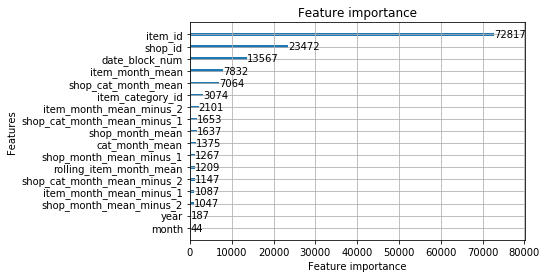

In [211]:
print('Plotting feature importances...')
ax = lgbm.plot_importance(model_lgb, max_num_features=20)
plt.show()

3.45 val > 3.70 submit
3.06 val > 3.65 submit